# Práctica 2 Detección de puntos relevantes y construcciín de panoramas 

Autor: Blanca Cano Camarero 
Fecha: Noviembre 2021 


In [1]:
'''
Ejecute esta celda. 
Salvo tener la necesidad de cambiar la ruta donde se leen las imágenes, no es necesario la lectura de ésta
celda, ya que contiene: 
1. Bibliotecas necesarias.
2. Indicación de la ruta de donde se toman las imágenes y la lectura de las imágenes.
3. Conjunto de funciones auxiliaras como las utilizadas para mostrar imágenes en pantalla. 
Éstas están tomadas de las prácticas 0 y 1 con a lo sumo tienen ligeras modificaciones.  
'''
# Import básicos
# Configuración previa 
# 1 modulos utilizados
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

# Funciones auxiliares necesarias de otras prácticas
# ___ Lectura de imágenes___
# path carpeta con imágenes
path = 'imagenes/'

# Devuelve si una imagen está en blanco o negro 
def IsGreyScale(img):
    '''Devuelve si una imagen está en blanco y negro'''
    return len(img.shape) == 2

# Reutilizamos código de la práctica inicial
def ReadImage(filename, flagColor):
  '''
  @param filename: nombre de la foto 
  @para flagColor: boolean escala de grises o color
  '''
  return np.asarray(cv.imread(filename, flagColor), dtype=float)

# Reutilizamos código de la práctica inicial
def ReadImageSinAsarray(filename, flagColor):
  '''
  @param filename: nombre de la foto 
  @para flagColor: boolean escala de grises o color
  '''
  return cv.imread(filename, flagColor)
## Flags
flagColor = cv.IMREAD_ANYCOLOR
flagGrey = cv.IMREAD_GRAYSCALE




# Devuelve si una imagen está en blanco o negro 
def IsGreyScale(img):
    '''Devuelve si una imagen está en blanco y negro'''
    return len(img.shape) == 2

# Para pintar imágenes
def Normalize (img):
    ''' Transforma una imagen de números reales
    al intervalo [0,1] 
    '''
    min = np.min(img)
    max = np.max(img)

    normalized_img = np.copy(img)

    if max - min > 0:
        normalized_img = (normalized_img - min) / (max - min)
    else: 
        normalized_img *= 0 # suponemos todo blanca
    return normalized_img

def PrintOneImage( img, title=None, normalize= True, size = (13,13)):
    '''Muestra una imagen usando imshow'''

    plt.figure(figsize=size)
    if normalize:
        img = Normalize(img)
    if IsGreyScale(img):
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    if title:
        plt.title(title)
    plt.show()

def RangoK (k: int):
    ''' dato k >= 0 devuelve [-k, -k+1, ...k-1, k]'''
    return list(range(-k, k+1))
def SacaRangoMascara(m):
    ''' Dada una máscata m, deduce su rango centrado
        Función auxiliar para representar máscaras
    '''
    return RangoK( (len(m)-1) // 2)
    
# Función para mostrar una máscara 
def MuestreaMascara( mascara:list, title = None,color= '--o'):
    dominio = RangoK((len(mascara)-1)//2)
    plt.plot(dominio, mascara, color)
    if (title):
        plt.title( title)
    plt.show()

# Función para comparar máscaras usando la norma euclídea
def DistanciaEuclidea (m1:np.array, m2:np.array)->float: 
    return np.linalg.norm(m1-m2)

# Función para mostrar dos máscaras 
### Comparamos las máscaras   
def MuestraDosMascaras ( m1, m2, title= None, title1 = None, title2 = None):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    if(title):
        fig.suptitle(title)
    # calculamos máscara 1
    r1 = SacaRangoMascara(m1)
    ax1.plot(r1, m1, '--o')
    if(title1):
        ax1.set_title( title1)
    # calculamos máscara 2
    r2 = SacaRangoMascara(m2)
    ax2.plot(r2, m2, '--x')
    if(title2):
        ax2.set_title(title2)
    fig.tight_layout()
    plt.show()

def PrintTwoImages(v_imagenes, v_titulos, titulo_principal):
    '''
    '''
    fig, axs = plt.subplots(1,2, figsize=(15,15))
    for i, img in enumerate(v_imagenes):
        if IsGreyScale(img):
            axs[i].imshow(img, cmap='gray')
        else:
            axs[i].imshow(img[:, :, ::-1])
        axs[i].set_title(v_titulos[i])

    fig.suptitle(titulo_principal)
    fig.tight_layout() # Para que no se solapen los subtítulos
   
    plt.show()
    plt.clf()


def UneImagenes(vim):

    num_imagenes = len(vim)

    alturas = []

    for i in range(0, num_imagenes):
        alturas.append( vim[i].shape[0])

    altura_maxima = np.max( alturas )

    # cogemos la primera imagen normalizada
    imagen_final = Normalize(vim[0])

    if imagen_final.shape[0] < altura_maxima:
        filas_restantes = altura_maxima - vim[0].shape[0]
        franja_negra = np.ones( (filas_restantes, vim[0].shape[1]))
        franja_negra = Normalize(franja_negra)
        imagen_final = np.vstack((imagen_final, franja_negra ))


    for i in range(1, num_imagenes):
        # para las siguientes imagenes, las normalizamos
        img = Normalize(vim[i])

        # si les faltan filas, añadimos las restantes como un borde negro
        if img.shape[0] < altura_maxima:
            filas_restantes = altura_maxima - img.shape[0]
            franja_negra = np.ones( (filas_restantes, img.shape[1]))
            franja_negra = Normalize(franja_negra)
            img = np.vstack((img, franja_negra ))

        imagen_final = np.hstack((imagen_final, img))

    return imagen_final

def PrintMultiplesImagenes(imagenes, titulo=None):
    """ Pinta múltiples imágenes"""
    fusion = UneImagenes(imagenes)
    PrintOneImage(fusion, titulo)


def PintaMultiplesImagenesConTitulos(v_img:list, titulos: list, columnas :int, filas:int ):
    '''Representa varias imágenes en una misma ventana
    Filas. 
    Debe de ser mayor de dos por dos 
    Suponemos:
        columnas * filas > len(v_img)
    '''
    # Gestionamos columanas y filas 
    numero_imagenes = len(v_img)
    # Preparamos grid
    fig, axs = plt.subplots(columnas, filas)

    for i in range(numero_imagenes):
        # pasamos a tribanda si está en monobanda
        if len(v_img[i].shape) != 3: 
            v_img[i] = cv.cvtColor(v_img[i], cv.COLOR_GRAY2RGB)
        # Calculamos posición en el grid
        x = i % columnas
        y = i // filas
        axs[x,y].imshow(v_img[i][:,:,::-1])
        
        # Añadimos título si lo tiene  
        if type(titulos)==list and len(titulos)>i:
            axs[x,y].set_title(titulos[i])
            
    fig.tight_layout() # Para que no se solapen los subtítulos
   
    plt.show()
    plt.clf()


## Apartado primero  

1.- (4 puntos) Extracción de regiones relevantes en un espacio de escalas.
Este punto se centra en detectar KeyPoints sobre cada una de las imágenes
de Yosemite.rar (usar versiones en rango de gris) y dibujarlos sobre las
imágenes haciendo uso de la función drawKeyPoints(). Para ello, se ha de
construir un Espacio de Escalas (pirámide) de Lowe con cuatro octavas en
total y tres escalas dentro de cada octava. Suponer que la imagen original está
afectada por un alisamiento debido a la captura de 𝜎 = 0.8 y queremos
introducir una primera octava de índice-0 de manera que la imagen semilla (
𝑣 01 ) en el espacio de escalas tenga un $\sigma=1.6$.

[] a)  ¿Qué operaciones sobre la imagen original de 𝜎 =0.8  nos permite 
fijar una  imagen semilla de 𝜎 = 1.6 ?   

Bastará con hacer interpolación para duplicar el tamaño de la imagen. 

TODO Justificación teórica. 


[] b)  Implementar una función que calcule las escalas de cualquier octava 
de la forma más eficiente posible. Es decir, reusable para cualquier 
escala.  



### Sobre la construcción del método de SIFT 

#### Documentación  
-  Diapositivas de teoría. 
- Artículo **Anatomy of the SIFT Method** de Ives Rey-Otero y Mauricio Delbracio. 
 http://dx.doi.org/10.5201/ipol.2014.82

#### Descripción general del algoritmo  

El método SIFT es un extractor e descriptores de la imagen invariante a traslaciones, rotaciones y escalado. 

El algoritmo consiste en dos procesos independientes: La detección de puntos de interés y extracción de descriptores de cada uno de ellos. Nos centraremos en el primero de los procesos en este apartado. 

##### Pasos del algoritmo 

1. Cálculo del espacio de escalas Gaussiano. 
2. Cálculo de las diferencias Gaussianas. 
3. Búsqueda de los puntos candidatos de interés. 

Los parámetros involucrados en la práctica son: 
- $\sigma_ {min} = 0.8$ inicial. 
- $n_{spo} = 3$ Numero de escalas por octava.
- $n_{oct} = 3$ Numero de octavas.


Para calcular las sucesivas imágenes 
##### Construcción de 1, cálculo del espacio de escalas Gaussiano  

Para ello se ha implementado la función auxiliar requisito 1B. 

Esta función consta de los siguientes parámetros: 
- Añadiremos además a cada octava tres nuevas imágenes $v_0^o$, $v_{n_{spo}}^o$, $v_{n_{spo}+ 2}$. 

Donde denotamos por $v$ al espacio de escalas construido, $v^o_i$ es la imagen i-ésima de la octava $o$. 

Para calcular cada escala 

$$V_s^o = G_ {\rho_[(s-1) \rightarrow s]} V^o_ {s-1},$$
donde 
$$\rho_[(s-1) \rightarrow s] = \frac{\sigma_{min}}{\delta_{min}} \sqrt{ 2^{ \frac{2s}{n_nspo}} - 2^{ \frac{2(s-1)}{n_nspo}}   }$$


###### Funciones auxiliares  

Reutilizaremos de la práctica primera la función de convolución y la de Gaussian Blur. 


In [2]:
# Funciones auxiliares de la práctica primera 

# Convolución 1D
def Convolve1DNotExpansive( row:np.array , _dx:np.array)-> np.array:
    ''' Convolution without adding padding'''
    dx = _dx[::-1]
    mask_len = len(dx)
    convolved = [ 
        np.dot( row[i:mask_len+i], dx)
        for i in range( len(row)-mask_len+1)
    ]
    return np.array(convolved)
    
# Implementación de convolución 2D en un canal
def ConvolveSeparableOneChannel(bordered_image, dx, dy):
    '''Suponemos imagen monobanda, 
        dx, dy máscaras en respectivos ejes en los que aplicar convolución 
    '''
    # convolve horizontal
    horizontal_convolved = np.array([Convolve1DNotExpansive(row, dx) for row in bordered_image])
    #convolve vertical  
    output = [Convolve1DNotExpansive(column, dy) for column in horizontal_convolved.T]
    return np.array(output).T

# # Implementación de convolución 2D para imagen genérica  
def ConvolveSeparable( image, dx, dy, border_type = cv.BORDER_REFLECT): 
    '''
    Recibe imagen realiza una convolución en 2D 
    '''
    # Calculamos el tamaño de los borderes
    x_padding = int( (len(dx) - 1) /2)
    y_padding =  int( (len(dy) - 1) /2)
    # padding order : top, bottom, left, right 
    bordered_image = cv.copyMakeBorder(image, y_padding, y_padding, x_padding, x_padding,  border_type)
    # controlamos que sea monobanda o tribanda, separando los canales
    if(IsGreyScale(image)):
        out_img = ConvolveSeparableOneChannel(bordered_image, dx, dy)
    else:
        #separamos canales
        channels = cv.split(bordered_image)
        out_img = cv.merge(
            [
                ConvolveSeparableOneChannel(one_channel_image, dx, dy)
                for one_channel_image in channels
            ]
        )
    return out_img

# ___________Para el cálculo de la máscaras Gaussianas_______________

# Declaración de la Gaussiana y su derivada primera y segunda
def Gaussiana (x: float, desviacion_tipica : float) -> float :
    return np.exp( - x**2 /(2* desviacion_tipica**2))

def DerivadaPrimeraGaussiana (x: float, desviacion_tipica : float)->float :
    #return -(Gaussiana (x, desviacion_tipica)* 2*x)
    return Gaussiana (x, desviacion_tipica)* 2*x

# Nota:para la primera derivada se toma sin pérdida de generalidad su versión positiva
# No afecta esta transformación porque su importancia como filtro es de detectar 
# cambios de intensidad, independientemente de que sean, negativos o positivos

def DerivadaSegundaGaussiana (x: float, desviacion_tipica : float)->float:
    return Gaussiana(x, desviacion_tipica) * ( x**2 - desviacion_tipica**2 )


# Implementación de las máscaras
# Comenzaremos definiendo funciones auxiliares: 
# Declaración de las funciones para calcular la máscara de tamaño T
def Mascara( f, size:int ):
    ''' Función auxiliar que devuelve estrictamente la máscara
        Devuelve la máscara de f de tamaño size 
        Requisito: size debe ser impar. 
    '''
    k = (size -1)//2
    return [f(i) for i in range(-k,k+1)]

# Definimos ahora las máscaras de la Gaussiana y sus derivadas, 
# Todavía dependen de la desviación típica y el tamaño de máscara, se generalizarán más adelante.
def MascaraGaussiana( desviacion_tipica:float, size:int)-> list:
    '''Máscara Gaussiana de tamaño "size"
    Requisito size debe ser impar 
    '''
    mascara_sin_normalizar = np.array(
        Mascara(lambda x: Gaussiana(x, desviacion_tipica), size),
        np.float64)
    suma = sum(mascara_sin_normalizar)
    return mascara_sin_normalizar/suma

def MascaraDerivadaPrimera(desviacion_tipica:float , size:int)->list:
    mascara_sin_normalizar =  np.array(
        Mascara(lambda x: DerivadaPrimeraGaussiana(x, desviacion_tipica), size),
        np.float64
    )
    return mascara_sin_normalizar

def MascaraDerivadaSegunda(desviacion_tipica:float , size:int)->list:
    mascara_sin_normalizar =  np.array(
        Mascara(lambda x: DerivadaSegundaGaussiana(x, desviacion_tipica), size),
        np.float64
    )
    return mascara_sin_normalizar

# Para un manejo más cómodo guardaremos la función en la siguiente lista 
MASKS_LIST = [MascaraGaussiana, MascaraDerivadaPrimera,MascaraDerivadaSegunda]

#La funciones creadas dependen de la desviación típica y del tamaño de la máscara. 
#Con el fin de hacerlas menos restrictivas en virtud de la relación T = 2 ceil(3 sigma) +1, 
#despejando T y sigma respectivamente obtenemos

def DeductSizeTFromSigma(sigma:float)-> int:
    ''' Calcula tamaño de másacara a partir de sigma'''
    return int(2* np.ceil(3*sigma) + 1)

def DeductSizeKFromSigma(sigma:float)-> int:
    ''' Calcula tamaño de másacara a partir de sigma'''
    return np.ceil(3*sigma)

def DeductSigmaFromT( T: int) -> float: 
    '''Ojo: se supone que 3 sigma = ceil(3sigma) = (T-1)/2'''
    return (T-1)/6.0

##### Implementación de la función general  que devuelve la máscara 
def MascarasGaussianasGeneral(orden : int, sigma: float =None, T: int = None) ->np.array: 
    '''Devuelve máscara de orden \in {0,1,2}
        Proporcionando sigma o T como dato, en  caso de que uno de ellos no sea dado lo deduce por 
        la relación ya mencionado
    '''
    # comprobación de que se cumplen las hipótesis
    assert 0<= orden <= 2
    assert sigma != None or T != None
    # Deducción pertinentes si son necesarias
    if( T == None):
        T = DeductSizeTFromSigma(sigma)
    elif(sigma == None):
        sigma = DeductSigmaFromT(T)

    return MASKS_LIST[orden](sigma, T)


In [3]:
'''             FUNCIONES EJERCICIO 1.B
    Función cálculo de la desviación de la máscara
    Función cálculo de las escalas de una octava
'''
# Comprobar si sigue una sucesión geométrica y en tal caso volver más eficiente
def Rho ( s, nspo = 3, delta_min = 0.5, sigma_min = 0.8) -> float: 
    '''
    Parámetros: 
    s \in [0,..,nspo+2]  imagen s-ésima
    nspo: número de escalas 
    delta_min: 1/interpolación
    sigma_min: Por defecto de la cámara 
    '''
    return np.float64(
       sigma_min / delta_min * np.sqrt( 2**(2*s/nspo) - 2**(2*(s-1)/nspo))
    )

def CalculaOctava (v_0, nsop = 3, delta_min = 0.5, sigma_min = 0.8): 
    ''' Calcula una octava
    Parámetros: 
    nsop: número de escalas por octavas

    Return: 
    Devuelve lista con las imágenes convolucionadas: [v_0, ..., v_{nsop}, v_{nsop+1}m v_{nsop+2}]
    '''
    octava = [v_0]
    for s in range(1, nsop+2): 
        # Cáculo del sigma
        rho_s = Rho(s, nsop, delta_min, sigma_min)
        # Calculamos máscara pertinente
        G_rho_s = MascarasGaussianasGeneral(0, rho_s)
        # Cálculo de la nueva imagen
        v_s = ConvolveSeparable( octava[-1], G_rho_s, G_rho_s)
        octava.append(v_s)
    return octava
        
    

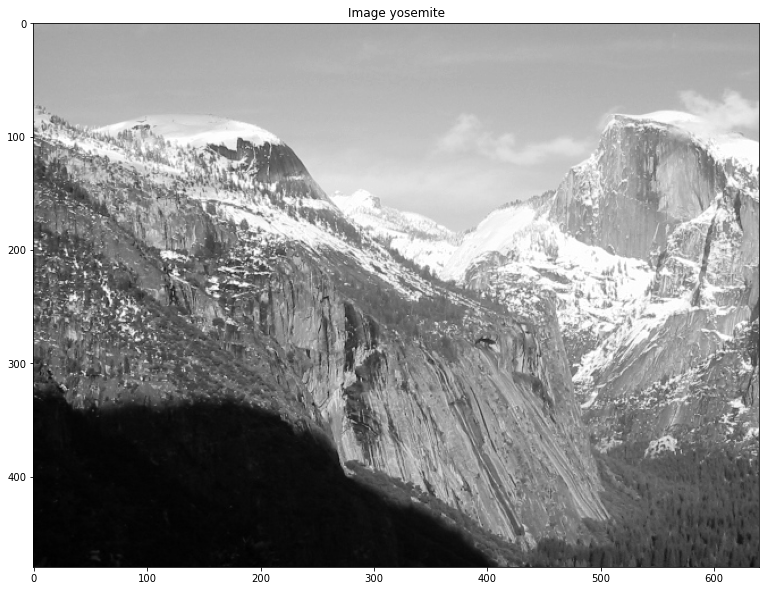

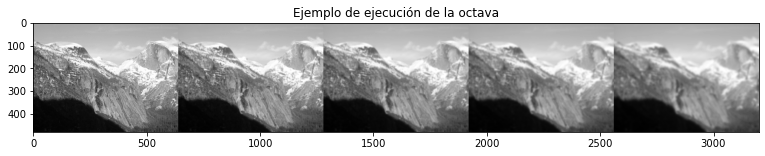

In [4]:
# Comprobación de la ejecución de la función

## leemos imagen 
img_yosemite1 = ReadImage('./yosemite/Yosemite1.jpg', flagGrey)#flagColor)
PrintOneImage(img_yosemite1, 'Image yosemite')

octava = CalculaOctava(img_yosemite1)
PrintMultiplesImagenes(octava, 'Ejemplo de ejecución de la octava')


[] c) Usar la función implementada en (b) para calcular las escalas de
todas las octavas (0-3). Mostrar las imágenes calculadas agrupadas
por octava (mostrar solo las escalas 1,2 y 3 en cada octava). 

Para ello primero necesitaremos: 
1. Calcula la interpolación. v_0
2. Calcular octava a partir de  v_0
3. (Si se desea otra nueva octava). Interpolar la cuarta imagen de la octava anterior. Volver al paso 2. 


In [5]:
def EspacioEscalasGaussiano( v_original, ns : int,): 
    '''
        v_original: imagen original
        ns número escalas, si ns = 3 entonces devuelve 4 escalas.
    '''
    indice_imagen_semilla = 3
    anchura = v_original.shape[1]
    altura = v_original.shape[0]
    v_0 =  cv.resize(
            src = v_original, dsize = (anchura*2, altura*2), 
            interpolation = cv.INTER_LINEAR # interpolación bilineal 
    )
    espacioEscalas = []
    for i in range(ns+1): 
        # Calculamos la escala
        espacioEscalas.append(CalculaOctava(v_0))
        # calculamos reescalado 
        imagen_semilla = np.copy(espacioEscalas[-1][indice_imagen_semilla])
        anchura = imagen_semilla.shape[1]
        altura = imagen_semilla.shape[0]
        v_0  =  cv.resize(
            src = imagen_semilla, dsize = (anchura//2, altura//2), 
            interpolation = cv.INTER_LINEAR # interpolación bilineal 
        )
    return espacioEscalas

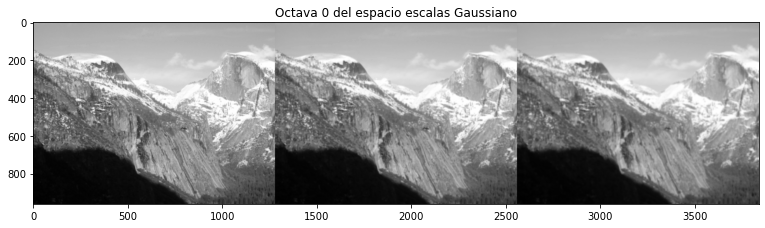

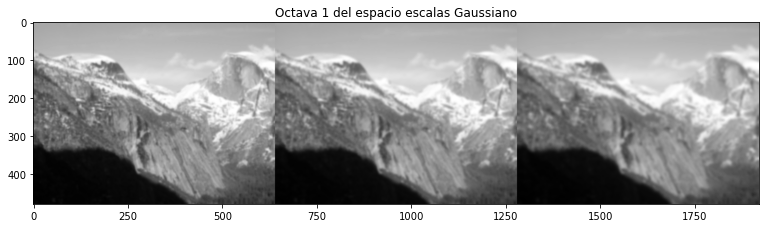

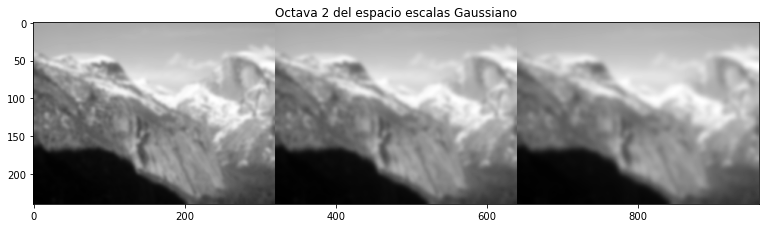

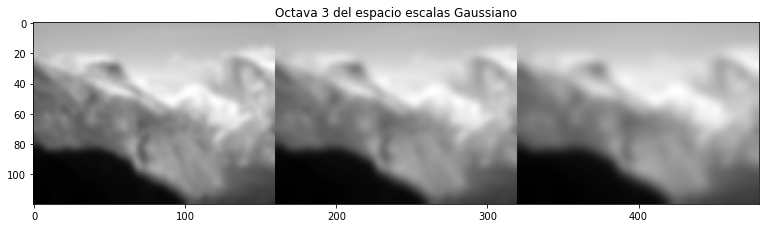

In [6]:
## Vamos a visualizar el espacio de escalas de nuestra imagen 
# tarda unos 35s en ejecutarse 
espacio_escalas_gaussiano = EspacioEscalasGaussiano(img_yosemite1, 3)
for i, octava in enumerate(espacio_escalas_gaussiano): 
    # mostramso solo escala 1,2,3
    PrintMultiplesImagenes(octava[1:4], f'Octava {i} del espacio escalas Gaussiano')

## Reflexión de porqué está funcionando

[] d)  
[] 1. Calcular el espacio de escalas Laplaciano a partir de la pirámide e
[] 2. identificar los 100 extremos locales con mayor respuesta, presentes
en la misma. 
[] 3. Extraer en un vector (x,y,$\sigma$) para cada uno de ellos en
los ejes de la imagen original.

## Cómo se va a solucionar   

Para el apartado 1 calcularemos la pirámide de Lowe, que consiste en restar los niveles adyacentes de cada octava del espacio de escalas Gaussiano, la función donde se resuelve es `PiramideLowe(piramide_gaussiana)`. 
En el enunciado se pide es espacio de escalas Laplaciano, en nuestro caso de va a impleentar la diferencia de gaussianas, (el operador DoG) ya que es una buena aproximación y se calcula de forma más eficiente. 
(TODO : profundizar en que es una aproximación y que se calcula de forma más eficiente)

Para el apartado 2, calcularemos máximos locales en 3D. Para hacer


In [7]:
# d1
def PiramideLowe(piramide_gaussiana):
    ''' Resta los niveles adyacentes de cada octava del espacio de escalas Gaussiano
    '''
    return np.array([
        [ octava[i] - octava[i+1] for i in range(len(octava)-1)] 
        for octava in piramide_gaussiana
    ])


/tmp/ipykernel_3691/4152383602.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([


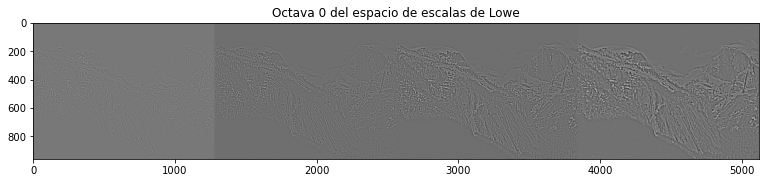

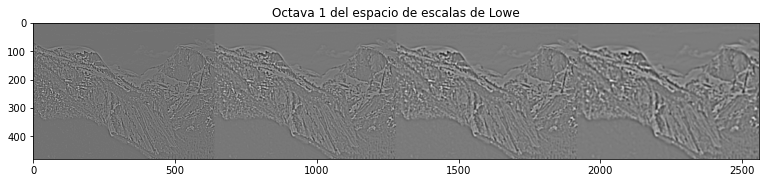

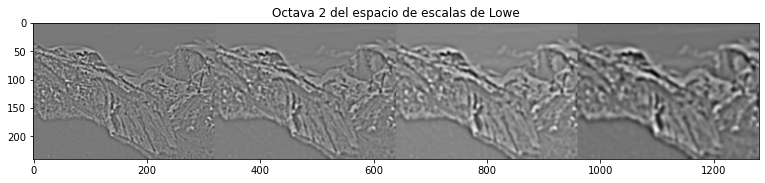

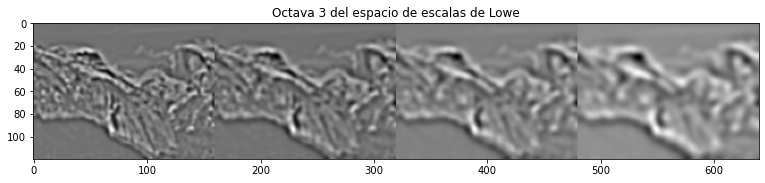

In [8]:
## Visualizamos su correcto funcionamiento 
espacio_escalas_laplaciano = PiramideLowe(espacio_escalas_gaussiano)
for i, octava in enumerate(espacio_escalas_laplaciano): 
    # mostramso solo escala 1,2,3
    PrintMultiplesImagenes(octava, f'Octava {i} del espacio de escalas de Lowe')

# duda ¿qué se hace con los extremos? ¿ahí no se mira?
# mayor estricto o mayor o igual ¿? 

In [9]:
# Tarda 1m con 7.5 segundos 
def BlurLevel( o:int,  s: int,  nspo = 3, delta_min = 0.5 , sigma_min = 0.8):
    delta_o = delta_min* 2**(o-1)
    sigma_o_s = delta_o / delta_min* sigma_min * 2**(float(s)/nspo)
    return sigma_o_s

def DetectaExtremos(espacio_escalas): 
    extremos = []
    for ind_octava, octava in enumerate(espacio_escalas):
        #calculamos tamaño de cada escala
        anchura = octava[0].shape[1]
        altura = octava[0].shape[0]
        # TODO : es muy poco efiente 
        for s in range( 1,len(octava)-1):
            for w in range(1,anchura-1):
                for h in range(1,altura-1):
                    contiguos = np.array([octava[i][h-1: h+2,w-1:w+2] for i in range(s-1, s+2)])
                    if (octava[s][h][w] == np.min(contiguos)):
                        extremos.append({'tipo_extremo':'min', 'octava': ind_octava, 
                        'nivel': s, 'x':w, 'y':h, 
                        'valor': octava[s][h][w],
                        'sigma': BlurLevel(ind_octava,s)})
                    elif (octava[s][h][w] == np.max(contiguos)):
                        extremos.append({'tipo_extremo':'max', 
                        'octava': ind_octava, 'nivel': s, 'x':w, 
                        'y':h,  'valor':octava[s][h][w], 'sigma': BlurLevel(ind_octava,s)})

    # ordenamos los extremos de más representativo
    extremos = sorted(extremos, key = lambda e : -e['valor'])

    return extremos

def ExpresaEnTupla(extremos, numero_tuplas):
    mas_representativos = extremos[:numero_tuplas]
    formato_tuplas = list(map(lambda e: (e['x'], e['y'], e['sigma']),mas_representativos))
    return formato_tuplas
    
# TODO DESCOMENTAR
#extremos = DetectaExtremos(espacio_escalas_laplaciano)
#key_points = ExpresaEnTupla(extremos, 100)
#print(key_points)

[(57, 401, 0.5039684199579493), (343, 435, 0.5039684199579493), (137, 492, 0.5039684199579493), (326, 482, 0.5039684199579493), (351, 438, 0.5039684199579493), (358, 459, 0.6349604207872798), (159, 513, 0.6349604207872798), (126, 469, 0.6349604207872798), (59, 524, 0.6349604207872798), (266, 414, 0.5039684199579493), (812, 480, 0.5039684199579493), (1233, 707, 0.5039684199579493), (402, 290, 0.6349604207872798), (1231, 718, 0.6349604207872798), (872, 482, 0.5039684199579493), (182, 506, 0.6349604207872798), (36, 242, 1.0079368399158986), (301, 322, 0.6349604207872798), (865, 537, 0.6349604207872798), (259, 299, 0.6349604207872798), (695, 477, 0.5039684199579493), (211, 146, 1.0079368399158986), (1125, 631, 0.6349604207872798), (125, 220, 1.0079368399158986), (173, 263, 1.0079368399158986), (620, 335, 1.2699208415745595), (523, 365, 0.5039684199579493), (418, 321, 0.5039684199579493), (197, 202, 1.0079368399158986), (466, 339, 0.6349604207872798), (369, 244, 0.6349604207872798), (443, 3

In [10]:
# Vamos a ver información sobre los key points 
def InformacionSobreKeyPoints ( extremos, noc): 
    numero_extremos = len(extremos)
    print( f'El número total de keypoints es {numero_extremos}')
    for i in range(noc):
        longitud = len(list(filter( lambda e : e['octava'] == i, extremos)))
        print(f'En la octava {i} hay {longitud} keypoints, un {np.round(longitud/numero_extremos,2)}%.')
    print('\nLos 100 más representativos se distribuyen: ')
    for i in range(noc):
        longitud = len(list(filter( lambda e : e['octava'] == i, extremos[:100])))
        print(f'En la octava {i} hay {longitud} keypoints, un {np.round(longitud/100,2)}%.')
    print('\n')
# TODO DESCOMENTAR
#InformacionSobreKeyPoints(extremos, len(espacio_escalas_laplaciano))
#print( extremos[0:10])

El número total de keypoints es 1495
En la octava 0 hay 704 keypoints, un 0.47%.
En la octava 1 hay 589 keypoints, un 0.39%.
En la octava 2 hay 161 keypoints, un 0.11%.
En la octava 3 hay 41 keypoints, un 0.03%.

Los 100 más representativos se distribuyen: 
En la octava 0 hay 73 keypoints, un 0.73%.
En la octava 1 hay 22 keypoints, un 0.22%.
En la octava 2 hay 3 keypoints, un 0.03%.
En la octava 3 hay 2 keypoints, un 0.02%.


[{'tipo_extremo': 'max', 'octava': 0, 'nivel': 1, 'x': 57, 'y': 401, 'valor': 26.308719102386533, 'sigma': 0.5039684199579493}, {'tipo_extremo': 'max', 'octava': 0, 'nivel': 1, 'x': 343, 'y': 435, 'valor': 24.493203488481413, 'sigma': 0.5039684199579493}, {'tipo_extremo': 'max', 'octava': 0, 'nivel': 1, 'x': 137, 'y': 492, 'valor': 23.109769553117218, 'sigma': 0.5039684199579493}, {'tipo_extremo': 'max', 'octava': 0, 'nivel': 1, 'x': 326, 'y': 482, 'valor': 22.943735657687995, 'sigma': 0.5039684199579493}, {'tipo_extremo': 'max', 'octava': 0, 'nivel': 1, 'x': 351,

## Apartado 1.e
[] e) Mostrar la imagen con los extremos locales extraídos usando para
ello un círculo de radio 6x sobre la escala de detección $\sigma$.

Para ello vamos a usar la función `drawKeyPoints()` 
que según la documentación oficial consultada a día 21 de noviembre: https://docs.opencv.org/3.4/d4/d5d/group__features2d__draw.html

Admite los siguientes parámetros: 
`	cv.drawKeypoints(	image, keypoints, outImage[, color[, flags]]	) -> 	outImage `

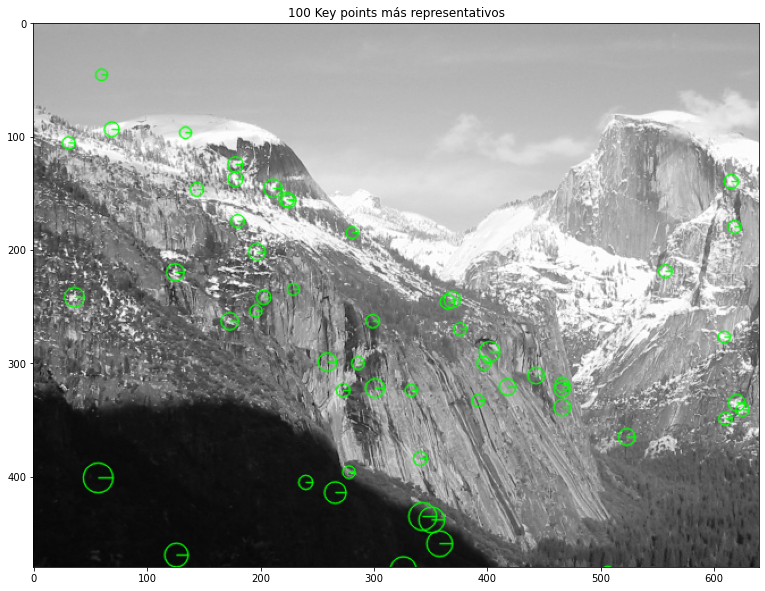

In [11]:
## Función apartado 1.e

def ExpresaEnKeyPoints (key_points):
    return list(map( lambda e: cv.KeyPoint(e['x'], e['y'], e['valor'], e['octava']),key_points))

#TODO DESCOMENTAR
#img = cv.drawKeypoints(np.uint8(img_yosemite1),ExpresaEnKeyPoints(extremos[:100]),np.array([]),(0,255,0), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#PrintOneImage(img, '100 Key points más representativos')

### Conclusiones
TODO

La mayoría de los keypoints se encuentran en las dos primeras escalas, lo cual es lo esperado. 

## Distintos apartados a completar en el ejercicio 1 son

[] a) ¿Qué operaciones sobre la imagen original de 𝜎 = 0.8 nos permite
fijar una imagen semilla de 𝜎 = 1.6 ?  

[] b) Implementar una función que calcule las escalas de cualquier octava
de la forma más eficiente posible. Es decir, reusable para cualquier
escala.

[] c) Usar la función implementada en (b) para calcular las escalas de
todas las octavas (0-3). Mostrar las imágenes calculadas agrupadas
por octava (mostrar solo las escalas 1,2 y 3 en cada octava). 

[] d) Calcular el espacio de escalas Laplaciano a partir de la pirámide e
identificar los 100 extremos locales con mayor respuesta, presentes
en la misma. Extraer en un vector (x,y,$\sigma$) para cada uno de ellos en
los ejes de la imagen original.

[] e) Mostrar la imagen con los extremos locales extraídos usando para
ello un círculo de radio 6x sobre la escala de detección $\sigma$.

[] f) Bonus.- (1 punto) Quién realice este punto usando código propio de
convolución y submuestreo (pirámide de Lowe).## Distintos apartados a completar en el ejercicio 1 son

[] a) ¿Qué operaciones sobre la imagen original de 𝜎 = 0.8 nos permite
fijar una imagen semilla de 𝜎 = 1.6 ?  

[] b) Implementar una función que calcule las escalas de cualquier octava
de la forma más eficiente posible. Es decir, reusable para cualquier
escala.

[] c) Usar la función implementada en (b) para calcular las escalas de
todas las octavas (0-3). Mostrar las imágenes calculadas agrupadas
por octava (mostrar solo las escalas 1,2 y 3 en cada octava). 

[] d) Calcular el espacio de escalas Laplaciano a partir de la pirámide e
identificar los 100 extremos locales con mayor respuesta, presentes
en la misma. Extraer en un vector (x,y,$\sigma$) para cada uno de ellos en
los ejes de la imagen original.

[] e) Mostrar la imagen con los extremos locales extraídos usando para
ello un círculo de radio 6x sobre la escala de detección $\sigma$.

[] f) Bonus.- (1 punto) Quién realice este punto usando código propio de
convolución y submuestreo (pirámide de Lowe).

# Dudas: ¿qué es la representación de un keypoints? ¿Cómo sacar el sigma?

# Reflexión sobre lo obtenido
TODO
Las frecuencias más altas podemos pensar que son las que tienen más detalle, luego es normal 

# Ejercicio 2 

2.-  (1.5 puntos)  (Correspondencias)   
[] Con cada dos de las imágenes de Yosemite con solapamiento detectar y 
extraer los descriptores SIFT de OpenCV, usando para ello la función cv2. 
detectAndCompute().     

[] Establecer los puntos en correspondencias existentes 
entre las dos imágenes usando el objeto BFMatcher de OpenCV 

[] y los criterios de correspondencias “BruteForce+crossCheck 
[]y “Lowe-Average-2NN”.  
[] Mostrar ambas imágenes en un mismo canvas 
[] y pintar líneas de diferentes colores 
entre las coordenadas de los puntos en correspondencias. Mostrar en cada 
caso un máximo de 100 elegidas aleatoriamente. 


## Función detecAndCompute
Buscamos en la documentación oficial a día 21 noviembre de 2021 de  SIFT`detectAndCompute`, cuyo link  es: 
-  https://docs.opencv.org/3.4/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677   
-  https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html  


```
cv.Feature2D.detectAndCompute(	image, mask[, descriptors[, useProvidedKeypoints]]	) -> 	keypoints, descriptors
```

### Función `BFMatcher`  

Bibliografia ( a día 22/10/21): 
- http://www.bim-times.com/opencv/4.3.0/dc/dc3/tutorial_py_matcher.html

Dadas dos imágenes, la función `BFMatcher` implementa el algoritmo de fuerza bruta, que consiste en tomar el descriptor de una característica de una imagen y emparejarlo con la característica de la segunda imagen  que más se aproxime a él.    

Acepta como parámetros la distancia a usar, que nosotros hemos elegido la norma euclídea, `NORM_L2` ya que por produce buenos resultados. 

El otro parámetro a configurar es `crossCheck`, que hemos configurado como `true` ya que es lo que se pide en el enunciado. 
Gracias a esto lo que se consigue es que solo se emparejen las parejas $(i,j)$ tal que el descriptor $i$ en primera imagen es emparejado con $j$, pero si se tomara el descriptor $j$ de la segunda, este se emparejaría con $i$.  Es decir, ambos son las mejores aproximaciones del otro. Este algoritmo fue propuesto en el paper SIFT de Lowe.  

El número de matches obtenido es de 1236.


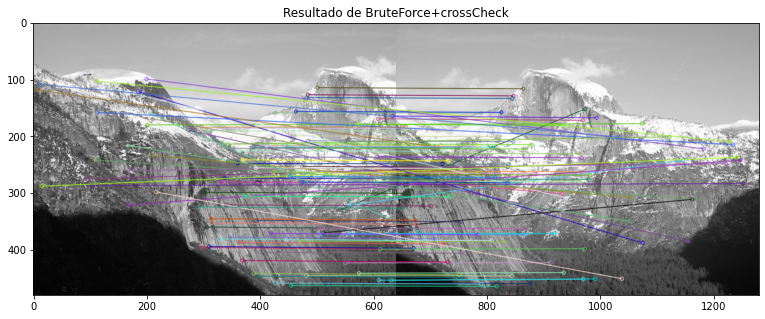

In [37]:
# Leemos las imágines pertinentes a esta práctica
img_yosemite1 = ReadImageSinAsarray('./yosemite/Yosemite1.jpg', flagGrey)
img_yosemite2 = ReadImageSinAsarray('./yosemite/Yosemite2.jpg', flagGrey)

# Inicializamos el detector de SIFT
sift = cv.SIFT_create()

# buscamos los keypoints y los descriptores  
kp1, des1 = sift.detectAndCompute(img_yosemite1,None)
kp2, des2 = sift.detectAndCompute(img_yosemite2,None)

#  Creamos BFMatcher el object0
# los criterios de correspondencias “BruteForce+crossCheck 
# norm_L2 es el valor por defecto, lo dejamos porque según la documentación oficial es funciona mejor
bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True) 

# Emparejamos los descriptores.
matches = np.array(bf.match(des1,des2))
print( f'El número de matches obtenido es de {len(matches)}.')
img3 = np.copy(img_yosemite1)
# mostramos 100 aleatorios
img3 = cv.drawMatches(img_yosemite1,kp1,
img_yosemite2,kp2,
np.random.choice(matches, 100, False),
img3,
flags=2)

PrintOneImage(img3, 'Resultado de BruteForce+crossCheck')

## Análisis del resultado   

La dirección en la que predominan las líneas paralelas es indicativo de cuál sería la homotopia correcta. Las líneas que se cruzan son errores, probablemente debidos a que la distancia entre esas características y las otras 

Se han obtenido 926


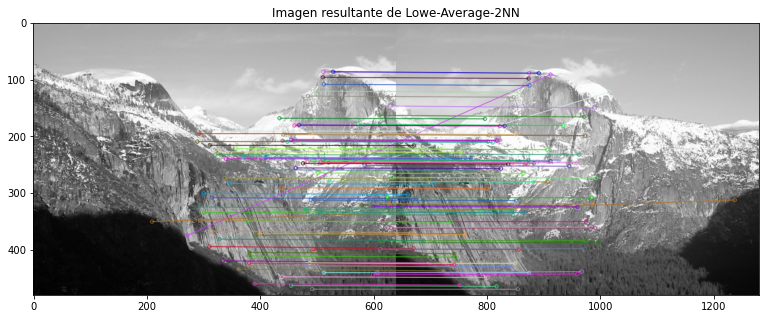

In [35]:
ratio_thresh = 0.75

sift = cv.SIFT_create()

# buscamos los keypoints y los descriptores  
kp1, des1 = sift.detectAndCompute(img_yosemite1,None)
kp2, des2 = sift.detectAndCompute(img_yosemite2,None)

# ya no es necesario aplicar el crossCheck 
# TODO quizás fuera interesante comparar qué pasaría si se aplicara
bf = cv.BFMatcher()
matches = np.array(bf.knnMatch(des1,des2, k=2))

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < ratio_thresh*n.distance:
        good.append(m)

print(f'Se han obtenido {len(good)} maches')
# cv2.drawMatchesKnn expects list of lists as matches.
good = np.array(good)

np.random.seed(1) #semilla 
randomMatches = np.random.choice(good, 100, False).reshape(-1,1)

img3 = cv.drawMatchesKnn(
    img_yosemite1,kp1,
    img_yosemite2,kp2,
    randomMatches,
    np.array([]),
    flags=2
)

PrintOneImage(img3, 'Imagen resultante de Lowe-Average-2NN')

### Conclusiones

Podemos comprobar que ahora la tendencia es mucho más fuerte que en el caso anterior.
Pero el método no es infalible como podemos ver en el ejemplo anterior ( por eso se fijó la semilla).  
Sigue habiendo casos extremos que se podrían eliminar volviendo más estricto el ratio, aunque a riesgo de disminuir el número de características emparejadas con éxito y existiendo la posibilidad de error. 

Se pone pues de manifiesto la necesidad de encontrar un equilibrio entre cuánto de estrictos ser y número de características obtenidas. 

Veamos ejemplo de esto en la siguiente celda. 

### TODO ¿Por lo general siempre habrá más en uno que en otro?



Se han obtenido 867 maches


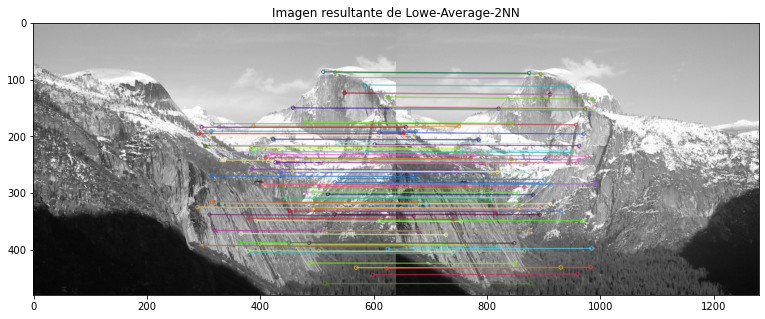

In [38]:
ratio_thresh = 0.5

sift = cv.SIFT_create()

# buscamos los keypoints y los descriptores  
kp1, des1 = sift.detectAndCompute(img_yosemite1,None)
kp2, des2 = sift.detectAndCompute(img_yosemite2,None)

# ya no es necesario aplicar el crossCheck 
# TODO quizás fuera interesante comparar qué pasaría si se aplicara
bf = cv.BFMatcher()
matches = np.array(bf.knnMatch(des1,des2, k=2))

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < ratio_thresh*n.distance:
        good.append(m)

# cv2.drawMatchesKnn expects list of lists as matches.

print(f'Se han obtenido {len(good)} maches')
good = np.array(good)

np.random.seed(1) #semilla 
randomMatches = np.random.choice(good, 100, False).reshape(-1,1)

img3 = cv.drawMatchesKnn(
    img_yosemite1,kp1,
    img_yosemite2,kp2,
    randomMatches,
    np.array([]),
    flags=2
)

PrintOneImage(img3, 'Imagen resultante de Lowe-Average-2NN')

# Conclusiones ejercicio 2

- Número de resultados (dependiente de la imagen?)
- otro métodos como RASAC


# Ejercicio 2 

2.-  (1.5 puntos)  (Correspondencias) 
[]Con cada dos de las imágenes de Yosemite con solapamiento detectar y 
extraer los descriptores SIFT de OpenCV, usando para ello la función cv2. 
detectAndCompute(). 
[] Establecer los puntos en correspondencias existentes 
entre las dos imágenes usando el objeto BFMatcher de OpenCV 

[] y los criterios de correspondencias “BruteForce+crossCheck 
[]y “Lowe-Average-2NN”.  
[] Mostrar ambas imágenes en un mismo canvas 
[] y pintar líneas de diferentes colores 
entre las coordenadas de los puntos en correspondencias. Mostrar en cada 
caso un máximo de 100 elegidas aleatoriamente. 